In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm_notebook
import Levenshtein
import re

import gensim

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_excel('asn.xlsx')

In [3]:
df.head()

,review_text,tema,mark
0,"первое дтп в водительской карьере, первый опыт...",Автострахование,5
1,Уважаемые господа! Это был первый и последний ...,Автострахование,1
2,Мой отец Рогов Сергей Дмитриевич в 2014 году з...,Имущественное страхование,Без оценки
3,"Сломал кость на кисти руки в гололёд, была стр...",Личное страхование,Без оценки
4,Страховой полис КАСКО- № 79089/046/3494384/6. ...,Автострахование,1


In [4]:
df.review_text.apply(len).describe()

count    20831.000000
mean      1031.860688
std       1005.525397
min         52.000000
25%        446.000000
50%        765.000000
75%       1271.000000
max      28057.000000
Name: review_text, dtype: float64

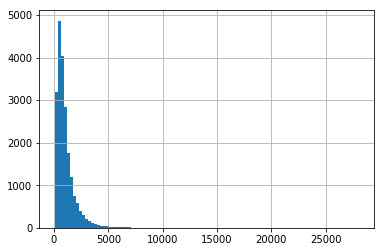

In [6]:
df.review_text.apply(len).hist(bins=100);

In [7]:
len(df)

20831

In [8]:
df.mark.value_counts()

1                            11105
5                             3147
Без оценки                    3125
2                             2004
3                              739
4                              711
Name: mark, dtype: int64

In [9]:
df.tema.value_counts()

Автострахование              18124
Личное страхование            1790
Имущественное страхование      916
Name: tema, dtype: int64

In [10]:
df.loc[1500,'review_text']

'Парковка для меня всегда была проблемой :) И вот очередной раз выезжая с парковки въехала в другой автомобиль. Задний бампер помят, у другого автомобиля также имелись повреждения. Пришлось звонить в контакт-центр Клувера. После моего звонка, ко мне сразу отправили аварийного комиссара. Специалист прибыл на парковку спустя 20 минут после моего обращения, а затем сам вызвал сотрудников ГИБДД. Мне даже не пришлось выходить из автомобиля, поскольку все вопросы решал аварком. Сотрудники прибыли на место аварии, все запротоколировали, специалист «Клувера» сделал фотографии, и буквально на следующий день я получила на руки направление на ремонт. Сейчас моим вопросом занимаются. Обещали привезти новый бампер, так что через несколько дней я отдам машину в ремонт. Я очень довольна тем, как аварийный комиссар Николай Коваценко решил все вопросы. Спасибо ему и «Клуверу». Я впервые страхуюсь по КАСКО и теперь поняла, как это удобно. Сам факт ДТП)'

In [12]:
#to lowercase
df.review_text = df.review_text.apply(str.lower)

In [199]:
df.loc[1500,'review_text']

'парковка для меня всегда была проблемой :) и вот очередной раз выезжая с парковки въехала в другой автомобиль. задний бампер помят, у другого автомобиля также имелись повреждения. пришлось звонить в контакт-центр клувера. после моего звонка, ко мне сразу отправили аварийного комиссара. специалист прибыл на парковку спустя 20 минут после моего обращения, а затем сам вызвал сотрудников гибдд. мне даже не пришлось выходить из автомобиля, поскольку все вопросы решал аварком. сотрудники прибыли на место аварии, все запротоколировали, специалист «клувера» сделал фотографии, и буквально на следующий день я получила на руки направление на ремонт. сейчас моим вопросом занимаются. обещали привезти новый бампер, так что через несколько дней я отдам машину в ремонт. я очень довольна тем, как аварийный комиссар николай коваценко решил все вопросы. спасибо ему и «клуверу». я впервые страхуюсь по каско и теперь поняла, как это удобно. сам факт дтп)'

In [13]:
#убрать символы и цифры
df.review_text = df.review_text.apply(lambda line: ''.join([i for i in line if i.isalpha() or i==' ']))

In [14]:
df.loc[1500,'review_text']

'парковка для меня всегда была проблемой  и вот очередной раз выезжая с парковки въехала в другой автомобиль задний бампер помят у другого автомобиля также имелись повреждения пришлось звонить в контактцентр клувера после моего звонка ко мне сразу отправили аварийного комиссара специалист прибыл на парковку спустя  минут после моего обращения а затем сам вызвал сотрудников гибдд мне даже не пришлось выходить из автомобиля поскольку все вопросы решал аварком сотрудники прибыли на место аварии все запротоколировали специалист клувера сделал фотографии и буквально на следующий день я получила на руки направление на ремонт сейчас моим вопросом занимаются обещали привезти новый бампер так что через несколько дней я отдам машину в ремонт я очень довольна тем как аварийный комиссар николай коваценко решил все вопросы спасибо ему и клуверу я впервые страхуюсь по каско и теперь поняла как это удобно сам факт дтп'

In [15]:
company_names = ['альфа',\
                 'ингосстрах','росгосстрах',\
                 'ресо','согласие','кардиф','вск',\
                 'югория','макс','ренессанс','втб',\
                 'интач','зетта','либерти','согаз',\
                 'гута','уралсиб','росно']

company_names+=[i+'-страхование' for i in company_names if not i.endswith('страх')]

def del_company_names(line):
    for name in company_names:
        for word in line.split():
            ldist = Levenshtein.distance(word.lower(),name)
            if ldist<=1:
                line = line.replace(word,'')
    return line

In [16]:
%%time
#убрать названия компаний
df.review_text = df.review_text.apply(del_company_names)

CPU times: user 1min, sys: 401 ms, total: 1min 1s
Wall time: 1min 1s


-------------

In [17]:
#проведем нормализацию текста
import pymorphy2

pymorphy2 написан на языке Python (работает под 2.7 и 3.3+). Он умеет:

- приводить слово к нормальной форме (например, “люди -> человек”, или “гулял -> гулять”).
- ставить слово в нужную форму. Например, ставить слово во множественное число, менять падеж слова и т.д.
- возвращать грамматическую информацию о слове (число, род, падеж, часть речи и т.д.)

При работе используется словарь OpenCorpora; для незнакомых слов строятся гипотезы. Библиотека достаточно быстрая: в настоящий момент скорость работы - от нескольких тыс слов/сек до > 100тыс слов/сек (в зависимости от выполняемой операции, интерпретатора и установленных пакетов); потребление памяти - 10...20Мб; полностью поддерживается буква ё.

In [18]:
morph = pymorphy2.MorphAnalyzer() #для нормализации текста

In [95]:
morph.parse('деньги')[0].normal_form

'деньга'

In [102]:
p = morph.parse('стали')
print(p[0].normal_form)
p

стать


[Parse(word='стали', tag=OpencorporaTag('VERB,perf,intr plur,past,indc'), normal_form='стать', score=0.984662, methods_stack=((<DictionaryAnalyzer>, 'стали', 904, 4),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,gent'), normal_form='сталь', score=0.003067, methods_stack=((<DictionaryAnalyzer>, 'стали', 13, 1),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,datv'), normal_form='сталь', score=0.003067, methods_stack=((<DictionaryAnalyzer>, 'стали', 13, 2),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn sing,loct'), normal_form='сталь', score=0.003067, methods_stack=((<DictionaryAnalyzer>, 'стали', 13, 5),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn plur,nomn'), normal_form='сталь', score=0.003067, methods_stack=((<DictionaryAnalyzer>, 'стали', 13, 6),)),
 Parse(word='стали', tag=OpencorporaTag('NOUN,inan,femn plur,accs'), normal_form='сталь', score=0.003067, methods_stack=((<DictionaryAnalyzer>, 'стали', 13, 9),))]

In [103]:
p = morph.parse('ебали') #к сожалению, pymorphy не очень хорош в случае ненормативной лексики
print(p[0].normal_form)
p

ебали


[Parse(word='ебали', tag=OpencorporaTag('NOUN,anim,masc,Fixd,Name sing,nomn'), normal_form='ебали', score=0.06686046511627906, methods_stack=((<DictionaryAnalyzer>, 'али', 62, 0), (<UnknownPrefixAnalyzer>, 'еб'))),
 Parse(word='ебали', tag=OpencorporaTag('NOUN,anim,masc,Fixd,Name sing,gent'), normal_form='ебали', score=0.06686046511627906, methods_stack=((<DictionaryAnalyzer>, 'али', 62, 1), (<UnknownPrefixAnalyzer>, 'еб'))),
 Parse(word='ебали', tag=OpencorporaTag('NOUN,anim,masc,Fixd,Name sing,datv'), normal_form='ебали', score=0.06686046511627906, methods_stack=((<DictionaryAnalyzer>, 'али', 62, 2), (<UnknownPrefixAnalyzer>, 'еб'))),
 Parse(word='ебали', tag=OpencorporaTag('NOUN,anim,masc,Fixd,Name sing,accs'), normal_form='ебали', score=0.06686046511627906, methods_stack=((<DictionaryAnalyzer>, 'али', 62, 3), (<UnknownPrefixAnalyzer>, 'еб'))),
 Parse(word='ебали', tag=OpencorporaTag('NOUN,anim,masc,Fixd,Name sing,ablt'), normal_form='ебали', score=0.06686046511627906, methods_stack

Но есть еще pymystem

This module contains a wrapper for an excellent morphological analyzer for Russian language Yandex Mystem 3.0 released in June 2014. A morphological analyzer can perform lemmatization of text and derive a set of morphological attributes for each token. For more details about the algorithm see I. Segalovich «A fast morphological algorithm with unknown word guessing induced by a dictionary for a web search engine», MLMTA-2003, Las Vegas, Nevada, USA.

In [20]:
import pymystem3

In [21]:
mstem = pymystem3.Mystem()

In [114]:
mstem.analyze('деньги')

[{'analysis': [{'gr': 'S,мн,неод=(вин|им)', 'lex': 'деньги'}],
  'text': 'деньги'},
 {'text': '\n'}]

In [115]:
mstem.analyze('стали')

[{'analysis': [{'gr': 'V,нп=прош,мн,изъяв,сов', 'lex': 'становиться'}],
  'text': 'стали'},
 {'text': '\n'}]

In [139]:
mstem.analyze('ебали')

[{'analysis': [{'gr': 'V,обсц,несов=прош,мн,изъяв', 'lex': 'ебать'}],
  'text': 'ебали'},
 {'text': '\n'}]

In [120]:
mstem.analyze('мы не стали этого делать')[4]

{'analysis': [{'gr': 'V,нп=прош,мн,изъяв,сов', 'lex': 'становиться'}],
 'text': 'стали'}

In [136]:
mstem.analyze('предмет сделан из стали')[6]

{'analysis': [{'gr': 'S,жен,неод=(пр,ед|вин,мн|дат,ед|род,ед|им,мн)',
   'lex': 'сталь'}],
 'text': 'стали'}

In [141]:
mstem.lemmatize('мы не стали этого делать')

['мы', ' ', 'не', ' ', 'становиться', ' ', 'это', ' ', 'делать', '\n']

-------------

In [22]:
from tqdm import tqdm
# Register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
# (can use `tqdm_gui`, `tqdm_notebook`, optional kwargs, etc.)
tqdm.pandas(desc='Progress bar')

In [23]:
#нормализация текста
df.review_text = df.review_text.progress_apply(lambda line: [morph.parse(word)[0].normal_form for word in line.split()])

Progress bar: 100%|██████████| 20831/20831 [11:20<00:00, 30.62it/s]


In [212]:
df.loc[1500,'review_text']

['парковка',
 'для',
 'я',
 'гда',
 'быть',
 'проблема',
 'и',
 'вот',
 'очередной',
 'раз',
 'выезжать',
 'с',
 'парковка',
 'въехать',
 'в',
 'другой',
 'автомобиль',
 'задний',
 'бампер',
 'помятый',
 'у',
 'другой',
 'автомобиль',
 'также',
 'иметься',
 'повреждение',
 'прийтись',
 'звонить',
 'в',
 'контактцентр',
 'клувера',
 'после',
 'мой',
 'звонок',
 'к',
 'я',
 'сразу',
 'отправить',
 'аварийный',
 'комиссар',
 'специалист',
 'прибыть',
 'на',
 'парковка',
 'спустя',
 'минута',
 'после',
 'мой',
 'обращение',
 'а',
 'затем',
 'сам',
 'вызвать',
 'сотрудник',
 'гибдд',
 'я',
 'даже',
 'не',
 'прийтись',
 'выходить',
 'из',
 'автомобиль',
 'поскольку',
 'вопрос',
 'решать',
 'аваркий',
 'сотрудник',
 'прибыть',
 'на',
 'место',
 'авария',
 'запротоколировать',
 'специалист',
 'клувера',
 'сделать',
 'фотография',
 'и',
 'буквально',
 'на',
 'следующий',
 'день',
 'я',
 'получить',
 'на',
 'рука',
 'направление',
 'на',
 'ремонт',
 'сейчас',
 'мой',
 'вопрос',
 'заниматься',
 '

In [24]:
#pip install stop-words
import stop_words
#или from nltk.corpus import stopwords

stopwords = stop_words.get_stop_words('russian')

In [25]:
stopwords[40:50]

['та', 'те', 'то', 'ту', 'ты', 'уж', 'без', 'был', 'вам', 'вас']

In [26]:
%%time
#убрать стопслова
df.review_text = df.review_text.apply(lambda line: [word for word in line if word not in stopwords])

CPU times: user 8.74 s, sys: 87.2 ms, total: 8.82 s
Wall time: 8.87 s


-------------

In [27]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split

In [28]:
df.mark = df.mark.apply(str.strip)

In [29]:
df.mark.unique()

array(['5', '1', 'Без оценки', '2', '3', '4'], dtype=object)

In [30]:
#сведем все к задаче бинарной классификаии
df.mark.replace({'1':0,'2':0,'3':0,'4':1,'5':1},inplace=True)

In [31]:
temp = df[df.mark.isin([0,1])].copy()

In [32]:
X = temp.review_text.apply(lambda line: ' '.join(line))
y = temp.mark

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
cvect = CountVectorizer(ngram_range=(1,2),max_df=0.8,min_df=0.01)

#TF-IDF (от англ. TF — term frequency, IDF — inverse document frequency)
#статистическая мера, используемая для оценки важности слова в контексте документа,
#являющегося частью коллекции документов или корпуса.
#Вес некоторого слова пропорционален количеству употребления этого слова в документе,
#и обратно пропорционален частоте употребления слова в других документах коллекции.
tfvect = TfidfVectorizer(ngram_range=(1,2),max_df=0.8,min_df=0.01)

In [35]:
X_train_cv = cvect.fit_transform(X_train)
X_train_tf = tfvect.fit_transform(X_train)

In [36]:
X_train_cv.shape,X_train_tf.shape

((13279, 1442), (13279, 1442))

In [37]:
X_test_cv = cvect.transform(X_test)
X_test_tf = tfvect.transform(X_test)

In [281]:
from sklearn.ensemble import RandomForestClassifier

In [291]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_cv,list(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [292]:
from sklearn.metrics import classification_report

In [294]:
print(classification_report(list(y_test),rfc.predict(X_test_cv)))

             precision    recall  f1-score   support

          0       0.89      0.99      0.94      3484
          1       0.92      0.59      0.72      1025

avg / total       0.90      0.89      0.89      4509



In [295]:
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train_tf,list(y_train))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [296]:
print(classification_report(list(y_test),rfc.predict(X_test_tf)))

             precision    recall  f1-score   support

          0       0.90      0.98      0.94      3484
          1       0.90      0.62      0.73      1025

avg / total       0.90      0.90      0.89      4509



In [297]:
rfc.feature_importances_

array([ 0.00041975,  0.00041861,  0.00010791, ...,  0.00012091,
        0.00017748,  0.0003418 ])

In [306]:
feats = {v:k for k,v in tfvect.vocabulary_.items()}

In [314]:
top10feats = np.argsort(rfc.feature_importances_)[-10:] #топ-10 фич по важности

In [315]:
for i in top10feats:
    print(feats[i])

выразить
вежливый
ответ
оперативность
оперативно
приятно
суд
благодарность
довольный
быстро


-------------

Gensim

In [64]:
import logging
logging.basicConfig(level=logging.INFO)

In [85]:
#собрать словарь из датасета
asndict = gensim.corpora.Dictionary(documents=df.review_text)
print(len(asndict))

#фильтрация слова по частотности слов
asndict.filter_extremes(no_below=15,no_above=0.65)
#чем меньше no_above, тем жестче фильтрует 0.1 - слово есть в 0.1 документов
#чем больше no_below, тем жестче фильтрует

#переназначает индекс
asndict.compactify()
print(len(asndict))

INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:adding document #10000 to Dictionary(38655 unique tokens: ['первое', 'дтп', 'водительский', 'карьера', 'опыт']...)
INFO:gensim.corpora.dictionary:adding document #20000 to Dictionary(65134 unique tokens: ['первое', 'дтп', 'водительский', 'карьера', 'опыт']...)
INFO:gensim.corpora.dictionary:built Dictionary(66917 unique tokens: ['первое', 'дтп', 'водительский', 'карьера', 'опыт']...) from 20831 documents (total 1773364 corpus positions)
INFO:gensim.corpora.dictionary:discarding 60566 tokens: [('карьера', 3), ('гиббдшник', 1), ('кафе', 7), ('рогов', 2), ('программеинвестиционный', 1), ('портфель', 11), ('альфастрахованиежизнь', 10), ('ls', 4), ('князев', 2), ('удостовериться', 8)]...
INFO:gensim.corpora.dictionary:keeping 6351 tokens which were in no less than 15 and no more than 13540 (=65.0%) documents
INFO:gensim.corpora.dictionary:resulting dictionary: Dictionary(6351 

66917
6351


Тематическая модель (topic model) — модель коллекции текстовых документов, которая определяет, к каким темам относится каждый документ коллекции. Алгоритм построения тематической модели получает на входе коллекцию текстовых документов. На выходе для каждого документа выдается числовой вектор, составленный из оценок степени принадлежности данного документа каждой из тем. Размерность этого вектора, равная числу тем, может либо задаваться на входе, либо определяться моделью автоматически.

Тематическое моделирование (topic modeling) — построение тематической модели.

Источник - http://www.machinelearning.ru/wiki/index.php?title=Тематическое_моделирование

Тематическая модель (англ. topic model) коллекции текстовых документов определяет, к каким темам относится каждый документ и какие слова (термины) образуют каждую тему.
https://ru.wikipedia.org/wiki/Тематическое_моделирование

Для примера рассмотрим Латентное размещение Дирихле (LDA, от англ. Latent Dirichlet allocation)

In [86]:
#обучение модели
num_topics=10
ldamodel = gensim.models.LdaModel(corpus=[asndict.doc2bow(t) for t in df.review_text],id2word=asndict,num_topics=num_topics)

INFO:gensim.models.ldamodel:using symmetric alpha at 0.1
INFO:gensim.models.ldamodel:using symmetric eta at 0.0001574555188159345
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (single-pass) LDA training, 10 topics, 1 passes over the supplied corpus of 20831 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #2000/20831
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 20831 documents
INFO:gensim.models.ldamodel:topic #7 (0.100): 0.023*"полис" + 0.013*"компания" + 0.009*"офис" + 0.009*"дать" + 0.009*"страховой" + 0.007*"сотрудник" + 0.007*"осаго" + 0.006*"страхование" + 0.006*"телефон" + 0.006*"автомобиль"
INFO:gensim.models.ldamodel:topic #3 (0.100): 0.019*"компания" + 0.011*"полис" + 0.010*"страховой" + 0.009*"получить" + 0.008*"сотрудн

INFO:gensim.models.ldamodel:topic diff=0.428977, rho=0.408248
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #14000/20831
INFO:gensim.models.ldamodel:merging changes from 2000 documents into a model of 20831 documents
INFO:gensim.models.ldamodel:topic #8 (0.100): 0.015*"страховой" + 0.014*"документ" + 0.013*"дело" + 0.011*"отказ" + 0.011*"тс" + 0.009*"правило" + 0.008*"случай" + 0.008*"постановление" + 0.007*"выплата" + 0.006*"дать"
INFO:gensim.models.ldamodel:topic #3 (0.100): 0.019*"компания" + 0.018*"месяц" + 0.015*"выплата" + 0.013*"ответ" + 0.013*"деньга" + 0.012*"ждать" + 0.012*"звонить" + 0.011*"страховой" + 0.010*"дело" + 0.008*"документ"
INFO:gensim.models.ldamodel:topic #0 (0.100): 0.031*"страховой" + 0.027*"компания" + 0.016*"случай" + 0.012*"выплата" + 0.011*"договор" + 0.010*"ремонт" + 0.009*"свой" + 0.009*"страхование" + 0.009*"документ" + 0.007*"получить"
INFO:gensim.models.ldamodel:topic #9 (0.100): 0.024*"ремонт" + 0.019*"машина" + 0.016*"страховой" + 0.014*

In [87]:
output = [ldamodel[t] for t in [asndict.doc2bow(t) for t in df.review_text]]

In [88]:
#вектор топиков для каждого документа, длина каждого вектора должна быть равна числу топиков
len(output[0]) #длина не всегда правильная, нужно переконвертировать
#бывает что если значение слишком близко к нулю, этот элемент выкидывает

5

In [89]:
#приведение всех векторов к одной длине - заполнение пропусков нулями
correct_output = []
for vector in tqdm_notebook(output):
    tempdict = {ind:value for ind,value in vector}
    correct_output.append([tempdict[i] if i in tempdict.keys() else 0 for i in range(num_topics)])

HBox(children=(IntProgress(value=0, max=20831), HTML(value='')))

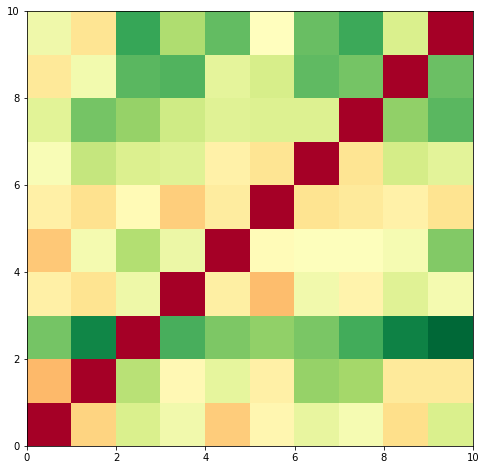

In [90]:
#ldamodel.diff(ldamodel) - матрица расстояний между топиками, второе - аннотация
dist_matrix = ldamodel.diff(ldamodel)[0] #попарные расстояние между темами
plt.figure(figsize=(8,8))
plt.pcolor(dist_matrix,cmap='RdYlGn')
plt.show()
#чем более зеленый оттенок, тем более разные темы

In [91]:
ldamodel.diff(ldamodel)[1][2][9] #пересечение 3 и 10 темы, отличия этих тем

[['страховка',
  'проблема',
  'обратиться',
  'говорить',
  'результат',
  'рубль',
  'страховой',
  'итог',
  'полис',
  'получить'],
 ['приехать',
  'ждать',
  'сервис',
  'новый',
  'быстро',
  'доктор',
  'цена',
  'эксперт',
  'приём',
  'ремонт']]

In [92]:
#все топики
ldamodel.show_topics(num_topics)

[(0,
  '0.035*"страховой" + 0.028*"компания" + 0.017*"случай" + 0.014*"выплата" + 0.010*"страхование" + 0.010*"свой" + 0.010*"договор" + 0.008*"ремонт" + 0.007*"возмещение" + 0.007*"автомобиль"'),
 (1,
  '0.025*"выплата" + 0.023*"страховой" + 0.020*"дтп" + 0.016*"сумма" + 0.015*"дело" + 0.014*"экспертиза" + 0.014*"документ" + 0.013*"суд" + 0.012*"компания" + 0.012*"автомобиль"'),
 (2,
  '0.018*"страховой" + 0.014*"компания" + 0.013*"врач" + 0.011*"ребёнок" + 0.010*"помощь" + 0.009*"страховка" + 0.009*"случай" + 0.008*"лечение" + 0.007*"деньга" + 0.007*"больница"'),
 (3,
  '0.020*"компания" + 0.019*"дело" + 0.019*"выплата" + 0.019*"деньга" + 0.018*"месяц" + 0.014*"ответ" + 0.012*"ждать" + 0.011*"страховой" + 0.011*"звонить" + 0.010*"документ"'),
 (4,
  '0.033*"договор" + 0.021*"страховой" + 0.019*"страхование" + 0.015*"полис" + 0.014*"компания" + 0.013*"заявление" + 0.011*"документ" + 0.008*"деньга" + 0.007*"получить" + 0.007*"сумма"'),
 (5,
  '0.019*"документ" + 0.018*"страховой" + 0.0

-------------

In [41]:
#pip install markovify
#Цепи Маркова
import markovify

In [42]:
#Считать текст
text = pd.read_excel('asn.xlsx')

In [43]:
text = text['review_text'].values

In [44]:
text[0]

'первое дтп в водительской карьере, первый опыт общения со страховой — камаз вьехал в дверь, помял пассажирскую дверь, и поцарапал и помял водительскую дверь и крыло. собрал все бумажки с гиббдшников, приехал в страховую. посоветовали ехать в четверг, меньше народу. у меня осаго. почитав негативные отзывы в интернете был готов к худшему. был приятно удивлен тем, что с подачей документов и оценкой ущерба уложился всего в час со всеми ожиданиями и фотографированиями. центр на нагорной — очень удобно, есть возможность подождать с комфортом, туалет, кафе и тд. все повреждения автомобиля подробно записали, ничего не пытались не вписывать, у меня не было претензий к оценщику. ровно через 20 дней на карточку перевели сумму, которая покрывает ремонт. следующая страховка будет только в ресо. номер дела пр7510089 претензий нет. молодцы.'

In [45]:
text = ' '.join(text)

In [46]:
#Запилить модель
text_model = markovify.Text(text)

In [52]:
text_model.make_sentence()

'В целом отношение к вам запрос на дополнительную учётную запись этого разговора я понял, что сделал он это сделает используя метод «НАЛОЖЕНИЯ РУК»? ГАЙДЕ не выполняет добросовестно свою работу.'

In [155]:
text_model.make_sentence()

'В общем, отношение - бери что дают добро обращаться в суд?'

In [156]:
text_model.make_short_sentence(140)

'Прождал еще около 3 х месяцев!!! Как не старалась страховая компания три месяца машина как новая.'

In [158]:
text_model.make_short_sentence(100)

'Надеюсь, в роддоме относятся с пониманием, все зарегистрировали.'

In [159]:
text_model.make_short_sentence(100)

'очень не понравилось, отвратительная компания, хамское отношение к людям.'

In [184]:
text_model.make_short_sentence(150)

'Будем обращаться в общество по защите прав потребителей, а может нет ,это недоказуемо ,пишу для тех кто им выдали лицензию.'

In [72]:
text_model.make_sentence_with_start('Беспредел')

'Беспредел полный и подробный.'

In [76]:
text_model.make_sentence_with_start('Хамло')

'Хамло и быдло самое настоящее!!! Ни какой суд мед экспертизы не согласны, будем оспаривать.'

In [109]:
text_model.make_sentence_with_start('очень')

'очень странно но он известен.'